In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings('ignore')

import os
%matplotlib inline

In [2]:
# Set file paths
data_file_path = "../data/"
train_data_folder = data_file_path+"training"
test_data_folder = data_file_path+"test"


### Read data from files and store in pandas dataframe

In [3]:
# Get stopwords
with open(data_file_path+"stopwords", 'r') as file:
    stopwords = file.read()
          
# Store the contents of all files in a list
all_files_data = []

# Loop through all files in the training folder
for f_name in os.listdir(train_data_folder):
    file_path = os.path.join(train_data_folder, f_name)
    
    # Ensure file is a regular file (not a directory)
    if os.path.isfile(file_path):
        # Read contents of the file
        with open(file_path, 'r') as file:
            file_data = file.read()
            all_files_data.append(file_data)
           

In [4]:
# Function to read topics from cats.txt and store in dictionaries
def read_topics(file_path):
    # Initialize dictionaries to store training and testing topics
    test_topics = {}
    train_topics = {}

    # Read topics from the file and store in respective dictionaries
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            if len(parts) >= 2:
                file_id = int(parts[0].split('/')[-1])  # Extract file ID from filename
                d_type = parts[0].split('/')[0]  # Extract data type (training/test)
                topic = ' '.join(parts[1:])  # Join remaining parts to form the complete topic string
                # Store training and testing topics separately
                topic = topic.split()
                if d_type == "training":
                    train_topics[file_id] = topic
                else:
                    test_topics[file_id] = topic
    return train_topics, test_topics

# Function to create DataFrame from files
def get_data(data_directory, topics):
    # Initialize an empty DataFrame
    data = {'File_ID': [], 'Title': [], 'Content': [], 'Topic': []}
    df = pd.DataFrame(data)

    # Iterate through files in the directory and populate the DataFrame
    for filename in os.listdir(data_directory):
        file_path = os.path.join(data_directory, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                # Read lines from the file
                lines = file.readlines()
                file_id = int(filename)  # Extract file ID
                title = lines[0].strip()  # Extract the title (first line)
                content = ''.join(lines[1:]).strip()  # Extract the content (rest of the file)
                topic = topics.get(file_id, None)  # Retrieve topic from topics dictionary
                # Append file details to the DataFrame
                df = df.append({'File_ID': file_id, 'Title': title, 'Content': content, 'Topic': topic}, ignore_index=True)
    # Display total records processed
    print(f"Total records processed: {len(df)}")
    return df


# Read topics from cats.txt
train_topics, test_topics = read_topics(data_file_path+"cats.txt")

# Get training and testing dataframes
print("Getting training data.")
df_train = get_data(train_data_folder, train_topics)
print("Getting testing data.")
df_test = get_data(test_data_folder, test_topics)

Getting training data.
Total records processed: 7769
Getting testing data.
Total records processed: 3019


## 1. Data Exploration and Preprocessing:


### Conduct exploratory data analysis to gain insights into the dataset's features and labels.

In [5]:
# Verify the number of files read is the same as files present in a folder
def verify_files(df, data_directory, data_str):
    # Get the number of files read from the DataFrame
    num_files_df = len(df)
    # Get the number of files present in the specified directory
    num_files_present = len(os.listdir(data_directory))
    
    # Verify if the number of files matches between DataFrame and directory
    if num_files_df == num_files_present:
        # Print success message if counts match
        print(f"{data_str} verification success with {num_files_df} files.\n")
    else:
        # Print failure message if counts don't match, along with counts for reference
        print(f"{data_str} verification fails.\n")
        print(f"Number of files read: {num_files_df}")
        print(f"Number of items in folder: {num_files_present}")

# Perform verification for training and testing dataframes
verify_files(df_train, train_data_folder, "Training Data")
verify_files(df_test, test_data_folder, "Test Data")


Training Data verification success with 7769 files.

Test Data verification success with 3019 files.



In [6]:
# Check for missing values in training data
if df_train.isnull().values.sum() == 0:
    print("No missing values found in Training Data!")
else:
    print("Missing values found in Training Data!")

# Check for missing values in testing data
if df_test.isnull().values.sum() == 0:
    print("No missing values found in Testing Data!")
else:
    print("Missing values found in Testing Data!")


No missing values found in Training Data!
No missing values found in Testing Data!


In [7]:
# Display the DataFrame heads
print("Training data:")
print(df_train.head())
print("\nTesting data:")
print(df_test.head())

Training data:
   File_ID                                              Title  \
0      1.0                                 BAHIA COCOA REVIEW   
1     10.0  COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...   
2    100.0    N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTLY   
3   1000.0  NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> BID   
4  10000.0  ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICANTLY   

                                             Content           Topic  
0  Showers continued throughout the week in\n  th...         [cocoa]  
1  Computer Terminal Systems Inc said\n  it has c...           [acq]  
2  New Zealand's trading bank seasonally\n  adjus...  [money-supply]  
3  Viacom International Inc said &lt;National\n  ...           [acq]  
4  Rogers Corp said first quarter\n  earnings wil...          [earn]  

Testing data:
   File_ID                                              Title  \
0  14826.0   ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT   
1  14828.0  CHINA DAILY

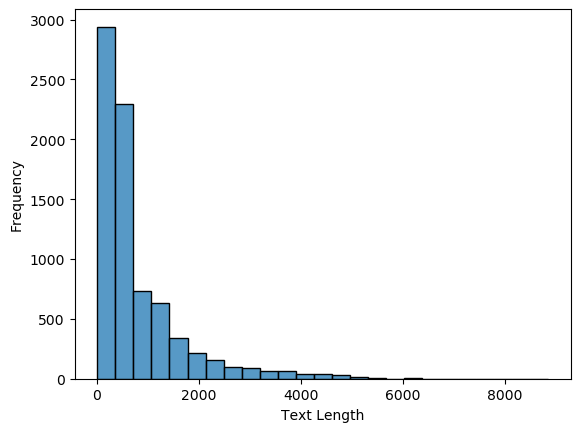

In [14]:
# Distribution of text lengths
ax = sns.histplot(df_train['Content'].apply(len), bins=25, label='Content')
ax.set(xlabel='Text Length', ylabel='Frequency')
plt.show()

# Extracting labels from the 'Topic' column of train and test dataframes
# Splitting multiple labels and combining them into lists
test_labels = [topic for topics in df_test['Topic'] for topic in topics]
train_labels = [topic for topics in df_train['Topic'] for topic in topics]


In [11]:
# View contents of rows where the 'Content' length is less than 100 characters
for i in range(len(df_train)):
    if len(df_train['Content'][i]) < 100:
        print(f"Index: {i}")
        print(df_train['Content'][i])

Index: 17
ENTERTAINMENT PUBLICATIONS SEES 31 CTS/SHR 3RD QTR LOSS ON UNITS DISPOSAL
Index: 27
FEDERATED DEPARTMENT STORES INC UPS QTLY DIV BY 10.5 PCT, SETS 2-FOR-1 STOCK SPLIT
Index: 33
Qtly div nine cts
      Pay April 30
      Record April six
Index: 35
AMERICAN BRANDS SEES RECORD FIRST QUARTER RESULTS
Index: 36
BP MANAGING DIRECTOR SAYS COMPANY DOES NOT PLAN TO HIKE 70 DLRS STANDARD OFFER
Index: 43
Qtly div 20 cts vs 19-1/2 cts prior
      Pay June 20
      Record June 5
Index: 44
FED'S HELLER SAYS DOLLAR'S CURRENT LEVEL IS APPROPRIATE
Index: 45
Qtly div 17-1/2 cts vs 17-1/2 cts prior
      Pay June 5
      Record May 22
Index: 47
MONEY MARKET MUTUAL FUNDS FALL 1.19 BILLION DLRS IN LATEST WEEK, ICI SAYS
Index: 56
Shr nil vs nil
      Net 130,998 vs 30,732
      Revs 1,568,941 vs 1,0053,234
Index: 59
Qtly div 32 cts vs 30 cts prior
      Pay April 29
      Record April 10
Index: 66
26-FEB-1987
Index: 74
Qtly div 68 cts vs 68 cts in prior qtr
      Payable May one
      Record April 

In [16]:
# Find topics present in test labels that are not present in train labels
topics_not_in_train = set(test_labels).difference(set(train_labels))

# Check if there are topics in test labels that are not in train labels
if len(topics_not_in_train) > 0:
    # Display topics present in test labels but not in train labels
    print("Topics present in test labels but not in train labels:")
    print(topics_not_in_train)
else:
    # If no extra topics found in test labels, print a message
    print("Test set does not have extra topics not found in train labels.")

Test set does not have extra topics not found in train labels.


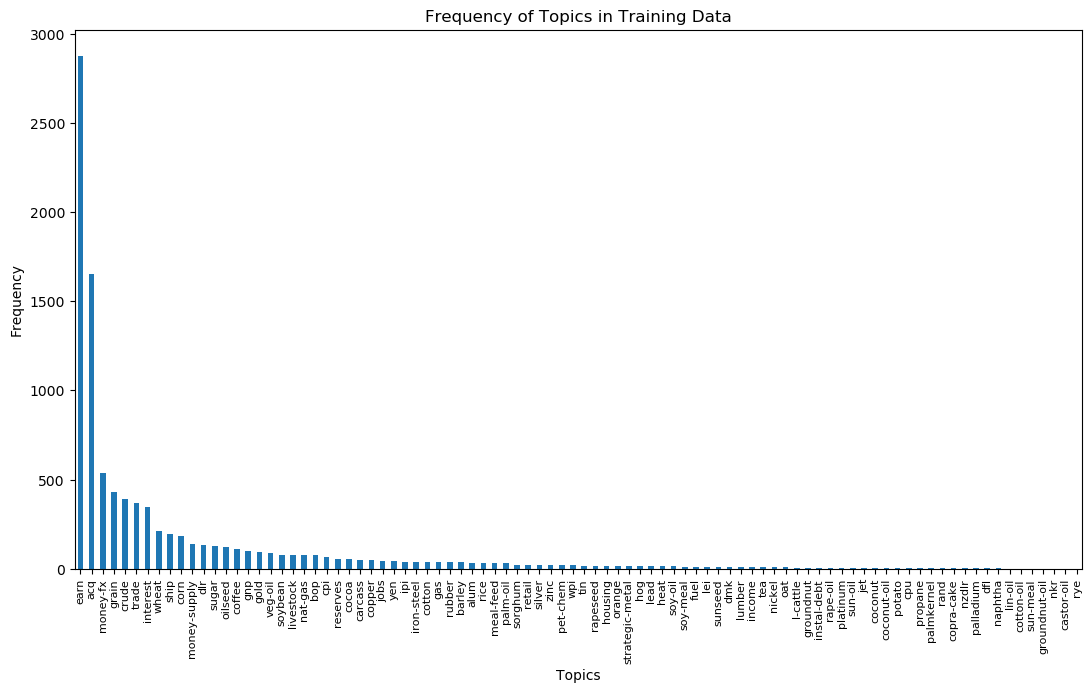

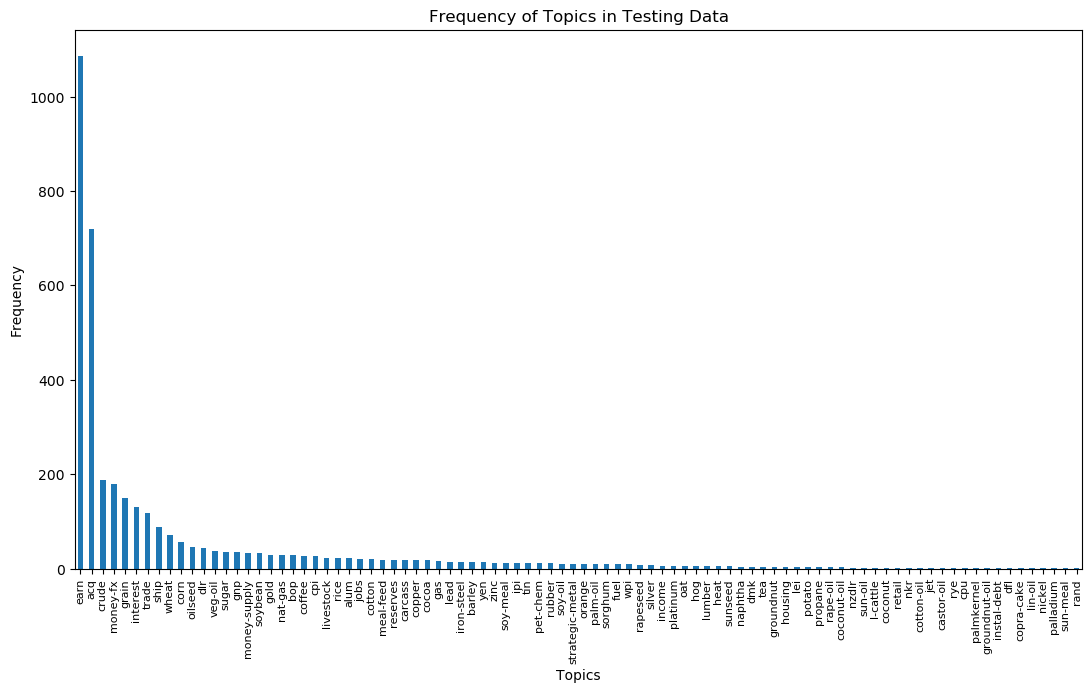

In [17]:
# Calculate and plot label frequencies
train_label_frequencies = pd.Series(Counter(train_labels)).sort_values(ascending=False)
test_label_frequencies = pd.Series(Counter(test_labels)).sort_values(ascending=False)

def plot_label_frequencies(label_frequencies, dat_type):

    # Plotting label frequencies
    plt.figure(figsize=(13, 7))
    label_frequencies.plot(kind='bar')
    plt.xlabel('Topics')
    plt.ylabel('Frequency')
    plt.xticks(fontsize=8)
    plt.title(f'Frequency of Topics in {dat_type} Data')
    plt.show()
    
plot_label_frequencies(train_label_frequencies, "Training")
plot_label_frequencies(test_label_frequencies, "Testing")



In [19]:
# Display unique Label frequencies in training data
unique_topic_keys = train_label_frequencies.keys()

# Print frequencies in a table format.
print("S.No. \t Topic \t\t\t Train frequency  Test frequency")
for idx, topic in enumerate(unique_topic_keys):
    print(f"{idx+1:>2}\t {topic:<25} {train_label_frequencies[topic]:>5}\t\t{test_label_frequencies[topic]:>4}")


S.No. 	 Topic 			 Train frequency  Test frequency
 1	 earn                       2877		1087
 2	 acq                        1650		 719
 3	 money-fx                    538		 179
 4	 grain                       433		 149
 5	 crude                       389		 189
 6	 trade                       368		 118
 7	 interest                    347		 131
 8	 wheat                       212		  71
 9	 ship                        197		  89
10	 corn                        182		  56
11	 money-supply                140		  34
12	 dlr                         131		  44
13	 sugar                       126		  36
14	 oilseed                     124		  47
15	 coffee                      111		  28
16	 gnp                         101		  35
17	 gold                         94		  30
18	 veg-oil                      87		  37
19	 soybean                      78		  33
20	 livestock                    75		  24
21	 nat-gas                      75		  30
22	 bop                          75		  30
23	 cpi                   

#### &rarr; This shows that the given data is unbalanced. 

### Implement suitable feature engineering and preprocessing techniques.

In [20]:
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize(text_data):
    # Create tokens for each document in dataframe, by first converting to lowercase
    # and Tokenizing the input. 
    # Then removing punctuations and taking only alphabets, then finally stemming the
    # word to its root word.
    tokens = word_tokenize(text_data.lower())
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    return tokens


In [22]:
# Stopwords are provided with the data. Tokenizing the stopwords and then 
# Vectorizing it with TF-IDF. Then transforming the text labels to numeric
# using multi label binarizer.

# Tokenize the stopwords for TF-IDF vectorization
stopwords_ = tokenize(stopwords)

# Initialize a TF-IDF vectorizer using the tokenization and stopwords
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords_)

# Initialize MultiLabelBinarizer for labels
mlb = MultiLabelBinarizer()

# Transform train and test documents and labels
train_documents = vectorizer.fit_transform(df_train["Content"])
train_labels = mlb.fit_transform(df_train["Topic"])
test_documents = vectorizer.transform(df_test["Content"])
test_labels = mlb.transform(df_test["Topic"])

## 2. Model Development:
#### Build a classification model to predict all categories associated with an article, using an algorithm(s) of your choice.



#### Provide a rationale for your choice of model and any hyperparameter tuning process.
I selected Random Forest classifier, which belongs to the class of ensemble methods
because those methods are considered superior when the dataset is imbalanced. [Tarekegn et. al.](https://www.sciencedirect.com/science/article/pii/S0031320321001527?casa_token=Y8nuFnU0rLsAAAAA:hafy229Vs3gOSBBY8AXRFx_hvpyhSNrrZ4QwNqUVegShCY2D53rVH_9gxh4HkkjqWsYJPUBi_OIzeA) 
Among ensemble methods, random forest classifier generally produces better results.

To select the hyper-parameter, I used grid search to search over differenct parameter values for 
number of trees estimator of Random Forest using 5 fold cross validation. The result is 400. 


In [ ]:
# Search the best value of parameter n_estimator for random Forest

# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600]}

# Initialize RandomForestClassifier
classifier = RandomForestClassifier(n_jobs=-1) # n_jobs=-1 to use all the processors

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_documents, train_labels)

# Get the best estimator and its parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Estimator:", best_estimator)
print("Best Parameters:", best_params)

In [62]:
def save_model(model, f_name):
    f_name = "../saved_models/"+f_name
    with open(f_name, 'wb') as fp:
        pickle.dump(model, fp)

        
def load_model(f_name):
    f_name = "../saved_models/"+f_name
    with open(f_name, 'rb') as fp:
        return pickle.load(fp)
    

In [24]:
# Initialize RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=400, n_jobs=-1)

# Fit the classifier to the training data
classifier.fit(train_documents, train_labels)

# Save the model
save_model(classifier, "RandomForest400.pkl")

# 3. Model Evaluation:
### Evaluate the model using relevant metrics.
### Analyze the performance across different labels and discuss any discrepancies observed.

In [63]:
classifier = load_model("RandomForest400.pkl")
# Test the model predictions on test_documents
test_labels_pred = classifier.predict(test_documents)

# Analyze the model preformance
print(classification_report(test_labels, test_labels_pred))

report = classification_report(test_labels, test_labels_pred, target_names=mlb.classes_, output_dict=True)

# Iterate through each label and analyze its performance metrics
for label in mlb.classes_:
    label_report = report[label]
    print(f"Label: {label}")
    print(f"Precision: {label_report['precision']}")
    print(f"Recall: {label_report['recall']}")
    print(f"F1-score: {label_report['f1-score']}")
    print(f"Support: {label_report['support']}")
    print("\n")

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       719
           1       1.00      0.04      0.08        23
           2       1.00      0.07      0.13        14
           3       1.00      0.10      0.18        30
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       1.00      0.21      0.35        28
          10       1.00      0.11      0.20        18
          11       0.00      0.00      0.00         1
          12       0.88      0.27      0.41        56
          13       1.00      0.05      0.10        20
          14       0.00      0.00      0.00         2
          15       0.75      0.11      0.19        28
          16       0.00      0.00      0.00         1
          17       1.00    

Due to high imbalance in data, the recall of classes whose occurance is less than 100 is lower compared to classes with higher occurance. 
This is a known problem in imbalance datasets and is a topic of ongoing research. 
As a future work on this problem, I would like to try loss balancing mechanism as described in [Huang et. al.](https://arxiv.org/pdf/2109.04712.pdf)

# 4. (Optional) Advanced Analysis:
### Explore a second approach, and discuss the trade-offs or benefits compared to your original approach.


In [53]:
from sklearn.model_selection import GridSearchCV
# Search the best value of parameter kernal, C and gamma for LinearSVC

# Define the parameter grid
param_grid = {'n_neighbors': [2,3,5,7,10,15]}

# Initialize KNeighborsClassifier
classifier = KNeighborsClassifier(n_jobs=-1)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(train_documents, train_labels)

# Get the best estimator and its parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Estimator:", best_estimator)
print("Best Parameters:", best_params)

Best Estimator: KNeighborsClassifier(n_jobs=-1, n_neighbors=2)
Best Parameters: {'n_neighbors': 2}


In [58]:
from sklearn.model_selection import GridSearchCV
# Search the best value of parameter kernal, C and gamma for LinearSVC

# Define the parameter grid
param_grid = {'n_neighbors':[2,3,5,7,10,15]}

# Initialize KNeighborsClassifier
classifier = KNeighborsClassifier(n_jobs=-1)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='precision')
grid_search.fit(train_documents, train_labels)

# Get the best estimator and its parameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Estimator:", best_estimator)
print("Best Parameters:", best_params)

Best Estimator: KNeighborsClassifier(n_jobs=-1, n_neighbors=2)
Best Parameters: {'n_neighbors': 2}


In [59]:
# Initialize KNeighborsClassifier
classifier = KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

# Fit the classifier to the training data
classifier.fit(train_documents, train_labels)

# Save the model
save_model(classifier, "KNeighborsClassifier.pkl")


In [60]:
# Analyze the classifier
classifier = load_model("KNeighborsClassifier.pkl")

# Predict labels for test data
test_labels_pred = classifier.predict(test_documents)


print(classification_report(test_labels, test_labels_pred))
report = classification_report(test_labels, test_labels_pred, target_names=mlb.classes_, output_dict=True)

# Iterate through each label and analyze its performance metrics
for label in mlb.classes_:
    label_report = report[label]
    print(f"Label: {label}")
    print(f"Precision: {label_report['precision']}")
    print(f"Recall: {label_report['recall']}")
    print(f"F1-score: {label_report['f1-score']}")
    print(f"Support: {label_report['support']}")
    print("\n")

              precision    recall  f1-score   support

           0       0.98      0.08      0.16       719
           1       1.00      0.04      0.08        23
           2       1.00      0.14      0.25        14
           3       0.83      0.17      0.28        30
           4       1.00      0.06      0.11        18
           5       0.00      0.00      0.00         1
           6       1.00      0.33      0.50        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.89      0.29      0.43        28
          10       0.80      0.22      0.35        18
          11       0.00      0.00      0.00         1
          12       0.90      0.32      0.47        56
          13       1.00      0.20      0.33        20
          14       0.00      0.00      0.00         2
          15       1.00      0.21      0.35        28
          16       0.00      0.00      0.00         1
          17       1.00    

One major benefit is that KNN is faster compared to Random forest. Though, looking at the results it is evident that the recall of KNN is in general lower compared to random forest in terms of micro averaged precision and recall, but not the other way around. 

This means that Random forest classifier performs better in predicting the majority classes or in capturing overall true positives and minimizing false positives and false negatives for the entire dataset.

Whereas KNN performs better in some classes to boost the overall macro precision and recall. 

# 5. Deliverables:
### Submit a well-documented Jupyter Notebook or equivalent, with clear code, comments, and analysis.
### Describe your approach, findings, and potential improvements or future work.
### (Optional) Create a short presentation (5-6 slides) to summarize your findings.